In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import utilities_visualization
from process_movella import load_movella, get_position, lowpass_filter
from utilities_hula_hoop import get_steady_hooping_interval, get_fixed_frame_acceleration, offset_hoop_sensor, estimate_period
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load Data

In [2]:
IN_DIR = Path("uploads/2025-08-12 Experiment 3/2025-08-12 Euler Angles")
OUT_DIR = Path("out")
# make the output directory if it does not exit
if not OUT_DIR.exists():
    OUT_DIR.mkdir()

In [3]:
# Constants

# Hoop specifications
d = 83./100     # m, hoop diameter
r = d/2         # m, hoop radius
m = 0.25        # kg, mass of hoop

# Gravity
g = 9.81        # m/s^2, gravitational acceleration

# Time setup
f = 120         # Hz, sampling frequency
dt = 1 / f      # s, sample duration

# Inertias in corotational basis
Ixx = 0.5*m*r**2
Iyy = 0.5*m*r**2
Izz = m*r**2

In [4]:
# Reading sensor data
sensor_ids = ['OR','OL','IB','IT','IL']
quantities = ['time','ax','ay','az','phi','theta','psi','wx','wy','wz']
sensors = {
    'OR': 'hoop',
    'OL': 'hip',
    'IB': 'femur',
    'IT': 'knee',
    'IL': 'ankle'
}

files = {
    sid : sorted(list(IN_DIR.glob(f"{sid}_*.csv")))[3]
    for sid in sensor_ids
}
raw_data = {
    sid: load_movella(files[sid], lead_time=0)
    for sid in sensor_ids
}
raw_data_dict = {}
for sid in sensor_ids:
    array = raw_data[sid]
    raw_data_dict[sid] = {q: array[:,i] for i,q in enumerate(quantities)}
    raw_data_dict[sid]['amag'] = np.sqrt(raw_data_dict[sid]['ax']**2 + raw_data_dict[sid]['ay']**2)

# time step
dt = raw_data_dict['OR']['time'][1]-raw_data_dict['OR']['time'][0]

# show a table of the data
print("Raw Data; Local Axes")
pd.DataFrame(raw_data_dict)

Raw Data; Local Axes


,OR,OL,IB,IT,IL
time,"[0.0, 0.008333, 0.016666, 0.024999, 0.033332, ...","[0.0, 0.008333, 0.016666, 0.024999, 0.033332, ...","[0.0, 0.008333, 0.016666, 0.024999, 0.033332, ...","[0.0, 0.008333, 0.016666, 0.024999, 0.033332, ...","[0.0, 0.008333, 0.016666, 0.024999, 0.033332, ..."
ax,"[-0.04511487107956674, -0.045977558905726745, ...","[-0.09117530822753928, 0.013623008728030683, -...","[-0.04775262832641758, 0.029260387420652734, 0...","[-0.008623285293580807, -0.026375932693481374,...","[-0.005083904266355077, 0.0050112152099641705,..."
ay,"[0.19315941810607917, 0.12572319984435953, 0.2...","[-0.06879551887511848, -0.04640449762344845, 0...","[-0.10290863990783294, -0.06736704587936293, -...","[-0.06353474855422858, -0.07374049425124862, -...","[-0.031176509857175905, -0.01731795310973583, ..."
az,"[-0.24581962585449268, -0.18971401214599304, -...","[0.04089843750000366, -0.02418697357177635, -0...","[0.07802940428257399, 0.0600435835123041, 0.05...","[0.02384299278259494, -0.0031769847869851375, ...","[-0.017135696411136436, -0.03668506622314638, ..."
phi,"[0.47568594429522404, 0.4752082397746911, 0.47...","[0.20478700110446474, 0.20468899677634983, 0.2...","[0.6592562733643273, 0.6593747174538087, 0.659...","[2.938054175693871, 2.937950312411358, 2.93793...","[-0.33222991190911666, -0.3322678286651366, -0..."
theta,"[0.04017470882784851, 0.039969620456777176, 0....","[-1.28944414343044, -1.2894741039927033, -1.28...","[-1.4364949772349636, -1.4365546320433815, -1....","[-1.1153954474962107, -1.1153899880159759, -1....","[-0.5085780809970611, -0.5085675615107553, -0...."
psi,"[0.030550770775818054, 0.030631262739171078, 0...","[-0.4311211725355698, -0.43090682135733205, -0...","[-0.8600202700366049, -0.8598814527647844, -0....","[-3.1021515041618284, -3.1020399177121547, -3....","[-0.18109638557447408, -0.1810755962732147, -0..."
wx,"[-0.15119303134024895, -0.15202496957527614, -...","[0.03416444110667645, 0.03447291006231313, 0.0...","[0.027613106436973536, 0.03304613815306012, 0....","[-0.00429237693466507, 3.487011127379492e-05, ...","[0.0198518248632366, 0.019943470894248905, 0.0..."
wy,"[-0.02976231488737019, -0.020714412337340265, ...","[0.0074628743735935775, 0.0022556048568373424,...","[-0.013274112415174207, -0.012878024419376572,...","[-0.018124188571615536, -0.01791809735394611, ...","[0.0324131151649212, 0.032532029468782524, 0.0..."
wz,"[0.00552020758959729, 0.005276116392123893, -0...","[0.007741835296292789, 0.002369603235803609, -...","[0.05063498141129918, 0.053328469248291654, 0....","[-0.023566160602705298, -0.024145986948069784,...","[0.01834257610338047, 0.019031036534679486, 0...."


In [5]:
data = np.vstack([raw_data_dict[sensor_id][quantity]
                        for sensor_id in sensor_ids
                        for quantity in quantities[1:]])
print(f"{data.shape=}")
np.save("data_experiment_3.npy", data)

data.shape=(45, 3273)


# Raw Data in the local axes

In [6]:
sensor_titles = [sensors[sid] for sid in sensor_ids]
fig = make_subplots(rows=len(sensor_titles), cols=1, subplot_titles=sensor_titles)
colors = {'psi': 'rgba(0, 0, 255, 0.7)','theta': 'rgba(255, 0, 0, 0.7)','phi': 'rgba(0, 128, 0, 0.7)'}
legend_shown = {'psi': False, 'theta': False, 'phi': False}

for i,sid in enumerate(sensor_ids, start=1):
    for angle_type,color in colors.items():
        fig.add_trace(go.Scatter(
            x=raw_data_dict[sid]['time'], 
            y=raw_data_dict[sid][angle_type], 
            mode='lines', 
            name=angle_type,
            legendgroup=f'{angle_type}',
            line=dict(color=color),
            showlegend=not legend_shown[angle_type]
        ), row=i, col=1)
        # Mark this legend item as shown after the first trace
        legend_shown[angle_type] = True

# Decrease margins and add a title
fig.update_layout(
    height=800,width=800,
    title_text="Raw Euler Angle Data",
    margin=dict(l=40, r=20, t=80, b=40),
)
fig.show()

In [7]:
fig = make_subplots(rows=len(sensor_titles), cols=1, subplot_titles=sensor_titles)
colors = {'ax': 'rgba(0, 0, 255, 0.7)','ay': 'rgba(255, 0, 0, 0.7)','az': 'rgba(0, 128, 0, 0.7)', 'amag': 'rgba(128, 0, 128, 0.8)'}
legend_shown = {'ax': False, 'ay': False, 'az': False, 'amag': False}

for i,sid in enumerate(sensor_ids, start=1):
    for a_type,color in colors.items():
        fig.add_trace(go.Scatter(
            x=raw_data_dict[sid]['time'], 
            y=raw_data_dict[sid][a_type], 
            mode='lines', 
            name=a_type,
            legendgroup=a_type,
            line=dict(color=color,width=1),
            showlegend=not legend_shown[a_type]
        ), row=i, col=1)
        # Mark this legend item as shown after the first trace
        legend_shown[a_type] = True

# Decrease margins and add a title
fig.update_layout(
    height=800,width=800,
    title_text="Raw Acceleration Data",
    margin=dict(l=40, r=20, t=80, b=40),
)
fig.show()

# Steady Hooping Interval

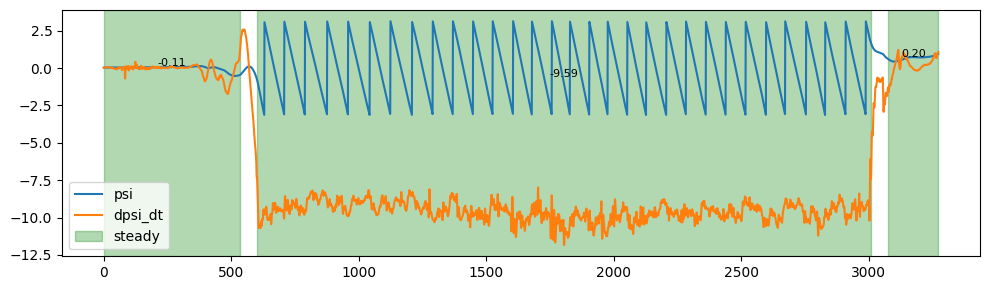

In [8]:
OR_groups, OR_averages = get_steady_hooping_interval(raw_data_dict['OR']['psi'], dt=dt, threshold=0.8)
t_active = OR_groups[1]
active_slice = slice(*t_active)

# Fixed Frame Data

In [9]:
fixed_data_dict = {}
accels = ['ax','ay','az']
for sid in sensor_ids:
    fixed_a = get_fixed_frame_acceleration(raw_data_dict[sid]['ax'], raw_data_dict[sid]['ay'], raw_data_dict[sid]['az'],
                                           raw_data_dict[sid]['psi'], raw_data_dict[sid]['theta'], raw_data_dict[sid]['phi'])
    fixed_data_dict[sid] = {a:fixed_a[i] for i,a in enumerate(accels)}
    fixed_data_dict[sid]['amag'] = np.sqrt(fixed_data_dict[sid]['ax']**2 + fixed_data_dict[sid]['ay']**2)

In [10]:
positions_velocities = ['dx','dy','dz','vx','vy','vz']
for sid in sensor_ids:
    array = get_position(raw_data_dict[sid]['time'],fixed_data_dict[sid]['ax'],fixed_data_dict[sid]['ay'],fixed_data_dict[sid]['az'],
                         degree=20,initial=0)
    for i,pv in enumerate(positions_velocities):
        fixed_data_dict[sid][pv] = array[i]

print("Fixed Frame Data")
pd.DataFrame(fixed_data_dict)

Fixed Frame Data


,OR,OL,IB,IT,IL
ax,"[-0.05896301578776502, -0.05644167175842728, -...","[-0.0773617195958658, 0.015416126926440583, 0....","[-0.10116352760782685, -0.06966614707382277, -...","[-0.026426284226741974, 0.0038821374603690874,...","[-0.007794149681501833, 0.01310652667768085, 0..."
ay,"[0.28261811433694833, 0.19695517542948737, 0.2...","[-0.04771214420630755, -0.05168319580384459, 0...","[-0.08042622689206438, -0.057068481555854395, ...","[-0.058491203500186655, -0.0727626596929659, -...","[-0.034216291341281575, -0.031207513498187886,..."
az,"[-0.12815445785725588, -0.10924587803307798, 0...","[-0.08035644388617771, 0.0038940671719650778, ...","[-0.04750423478281718, 0.029825114053688352, 0...","[-0.023663141021462324, -0.028878502616144438,...","[-0.007742711317721242, -0.022915669776288047,..."
amag,"[0.28870336988362405, 0.20488290177402846, 0.2...","[0.09089160777317593, 0.05393338203664466, 0.0...","[0.1292379096478791, 0.09005655797998499, 0.07...","[0.06418387168855427, 0.07286614877194736, 0.0...","[0.035092782198183084, 0.03384804189746194, 0...."
dx,"[0.07792414602988212, 0.06550863274667977, 0.0...","[0.047412031892455395, 0.03985616301399914, 0....","[0.08169806999864777, 0.06887947704363341, 0.0...","[0.14651255100551203, 0.12558842545683174, 0.1...","[0.06385389493494037, 0.05580227255247516, 0.0..."
dy,"[0.221587733553557, 0.19022561525109763, 0.161...","[0.026964185736031803, 0.023774324963598662, 0...","[0.05568114221114143, 0.04769854933470712, 0.0...","[0.05058746059197504, 0.042927735119042076, 0....","[0.04889746483591265, 0.03933584795465477, 0.0..."
dz,"[-0.01930236914990422, -0.016605381353258716, ...","[-0.004982560029152509, -0.004185064924951429,...","[-0.013852070486680869, -0.011676086245465312,...","[-0.008750173240857216, -0.007304449328013413,...","[-0.017466835644086583, -0.014418714411160443,..."
vx,"[-0.28969657794805403, -0.252291343252389, -0....","[-0.17702802671391993, -0.15298047436830797, -...","[-0.28026390458023265, -0.24334870787099994, -...","[-0.25262988046707857, -0.22313361633897602, -...","[0.020326055193053527, 0.011821539482144173, 0..."
vy,"[-0.34891248164233213, -0.30681785960214053, -...","[0.03365281568502487, 0.027199525242876915, 0....","[-0.0995483331670104, -0.0881201748124453, -0....","[-0.13972772535829092, -0.12224110910408734, -...","[-0.3956609449114392, -0.3419763488495598, -0...."
vz,"[0.026759117354989925, 0.022530581711632212, 0...","[0.019324691173030928, 0.01613826284780813, 0....","[0.04807537924457561, 0.04131002603671784, 0.0...","[0.038900771074671825, 0.033506778998004555, 0...","[0.09705035817511631, 0.08394304232356962, 0.0..."


In [11]:
fig = make_subplots(rows=len(sensor_titles), cols=1, subplot_titles=sensor_titles)
legend_shown = {'ax': False, 'ay': False, 'az': False, 'amag': False}

for i,sid in enumerate(sensor_ids, start=1):
    for a_type,color in colors.items():
        fig.add_trace(go.Scatter(
            x=raw_data_dict[sid]['time'], 
            y=fixed_data_dict[sid][a_type], 
            mode='lines', 
            name=a_type,
            legendgroup=a_type,
            line=dict(color=color,width=1),
            showlegend=not legend_shown[a_type]
        ), row=i, col=1)
        # Mark this legend item as shown after the first trace
        legend_shown[a_type] = True

# Decrease margins and add a title
fig.update_layout(
    height=800,width=800,
    title_text="Fixed Frame Acceleration Data",
    margin=dict(l=40, r=20, t=80, b=40),
)
fig.show()

In [12]:
fig_hooppath = go.Figure()
fig_hooppath.add_trace(go.Scatter3d(x=fixed_data_dict['OR']['dx'], y=fixed_data_dict['OR']['dy'], z=fixed_data_dict['OR']['dz'], mode='lines', name='hoop'))
fig_hooppath.update_layout(height=500,width=600,
    title_text="Hoop Sensor Displacement"
)
fig_hooppath.show()